In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
# # Mount
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# Import Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
from sklearn.cluster import KMeans
%matplotlib inline

plt.rc('font', family='NanumBarunGothic')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
scf = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/CARD_SPENDING_FOREIGNER.txt', sep='\t', encoding='cp949')
# scr = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/CARD_SPENDING_RESIDENT.txt', sep='\t', encoding='cp949')

dong = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/전체동별클러스터링.csv', sep = ',', encoding='utf-8')
dong_cd = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/SC동코드변환.csv', sep = ',', encoding='utf-8')

In [ ]:
# SCR = scr
SCF = scf

# **신한카드 외국인 데이터 분석**

In [ ]:
# 코드 -> 이름으로 바꾸는 함수 : name_a_to_b
def name_a_to_b(data,col,a,b):
  data = data.replace({col:a}, {col:b}, inplace=True)
  return(data)

# 카테고리 코드 -> 이름
cat_code = [10,20,21,22,30,31,32,33,34,35,40,42,43,44,50,52,60,62,70,71,80,81,92]
cat_name = ['숙박','레저용품','레저업소','문화취미','가구','전기','주방용구',
            '연료판매','광학제품','가전','유통업','의복','직물','신변잡화','서적문구','사무통신',
            '자동차판매','자동차정비','의료기관','보건위생','요식업소','음료식품','수리서비스']
for i in range(len(cat_code)):
  name_a_to_b(scf,'MCT_CAT_CD',cat_code[i],cat_name[i])

# 시구 및 동 이름 추가
scf = pd.merge(scf, dong_cd, left_on=['GU_CD', 'DONG_CD'], right_on=['GU_CD', 'HDONG_CD'])
scf = scf.drop(['GU_CD', 'DONG_CD', 'HDONG_CD'], axis=1)

# 날짜 형식으로 변환(int->str->date)
scf.STD_DD = pd.to_datetime(scf['STD_DD'].astype(str), format='%Y%m%d',infer_datetime_format=True)

# 클러스터링 추가
scf = pd.merge(scf, dong, left_on='HDONG_NM', right_on='HDONG_NM')

scf = scf[scf['SIDO_NM'] == '서울']
SCF = scf

In [ ]:
scf_cat = scf.groupby(['STD_DD','MCT_CAT_CD']).sum().unstack().fillna(0)
scf_cat

USE_CNT                   ... USE_AMT                     
MCT_CAT_CD      가구   가전  광학제품  레저업소  ...   자동차판매    전기    주방용구     직물
STD_DD                               ...                             
2019-02-01     0.0  4.0   8.0  11.0  ...     0.0   0.0  3188.0  450.0
2019-02-02     0.0  3.0   8.0  15.0  ...   300.0   0.0   242.0  533.0
2019-02-03     0.0  2.0  16.0  19.0  ...     0.0   0.0     0.0  183.0
2019-02-04     0.0  4.0   4.0  14.0  ...     0.0   0.0    13.0  206.0
2019-02-05     0.0  4.0   5.0  19.0  ...     0.0   0.0     0.0  161.0
...            ...  ...   ...   ...  ...     ...   ...     ...    ...
2020-05-27     1.0  0.0   4.0   6.0  ...     0.0  52.0     0.0    0.0
2020-05-28     0.0  0.0   0.0   7.0  ...  1468.0   0.0    42.0   12.0
2020-05-29     1.0  1.0   4.0   4.0  ...     0.0   0.0    98.0   23.0
2020-05-30     0.0  1.0   2.0  14.0  ...  7375.0   0.0    52.0   49.0
2020-05-31     0.0  1.0   0.0   5.0  ...     0.0   0.0     0.0   14.0

[241 rows x 46 columns]

In [ ]:
# 설날 2019 2월 4,5,6일 보정
scf_cat = scf.groupby(['STD_DD','MCT_CAT_CD']).sum().fillna(0).unstack()
for i in ['USE_CNT','USE_AMT']:
  scf_cat.xs(i,axis=1,level=0).loc['2019-02-04'] = (scf_cat.xs(i,axis=1,level=0).loc['2019-02-11']+scf_cat.xs(i,axis=1,level=0).loc['2019-02-18'])/2
  scf_cat.xs(i,axis=1,level=0).loc['2019-02-05'] = (scf_cat.xs(i,axis=1,level=0).loc['2019-02-12']+scf_cat.xs(i,axis=1,level=0).loc['2019-02-19'])/2
  scf_cat.xs(i,axis=1,level=0).loc['2019-02-06'] = (scf_cat.xs(i,axis=1,level=0).loc['2019-02-13']+scf_cat.xs(i,axis=1,level=0).loc['2019-02-20'])/2
  
scf_cat = scf_cat.reset_index(drop=False)
scf_cat = scf_cat[scf_cat.STD_DD != '2019-02-01'] ; scf_cat = scf_cat[scf_cat.STD_DD != '2020-05-30'] ; scf_cat = scf_cat[scf_cat.STD_DD != '2020-05-31'] 
scf_cat = scf_cat.set_index('STD_DD').fillna(0)


In [ ]:
scf_cat_list = list(scf_cat.xs('USE_AMT', axis=1, level=0).sum().sort_values(ascending=False).index)#.reset_index()
scf_cat_amt =  scf_cat.xs('USE_AMT', axis=1, level=0).reindex(columns=scf_cat_list)
scf_cat_cnt =  scf_cat.xs('USE_CNT', axis=1, level=0).reindex(columns=scf_cat_list)

scf_cat_amt_list = scf_cat.xs('USE_AMT', axis=1, level=0).sum().sort_values(ascending=False).index
print(scf_cat_amt_list[:5])
scf_cat_cnt_list = scf_cat.xs('USE_CNT', axis=1, level=0).sum().sort_values(ascending=False).index
print(scf_cat_cnt_list[:5])

Index(['유통업', '숙박', '요식업소', '보건위생', '의복'], dtype='object', name='MCT_CAT_CD')
Index(['유통업', '요식업소', '숙박', '보건위생', '의복'], dtype='object', name='MCT_CAT_CD')


In [ ]:
print(scf_cat_amt_list[:10])
print(scf_cat_cnt_list[:10])

Index(['유통업', '숙박', '요식업소', '보건위생', '의복', '레저용품', '자동차정비', '의료기관', '신변잡화',
       '음료식품'],
      dtype='object', name='MCT_CAT_CD')
Index(['유통업', '요식업소', '숙박', '보건위생', '의복', '자동차정비', '레저용품', '신변잡화', '음료식품',
       '서적문구'],
      dtype='object', name='MCT_CAT_CD')


In [ ]:
print('[\'유통업\',\'숙박\',\'요식업소\',\'보건위생\']')
print('외국인 이용금액 비율',scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_AMT[['유통업','숙박','요식업소']].sum() / scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_AMT.sum())
print('외국인 이용건수 비율',scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_CNT[['유통업','숙박','요식업소']].sum() / scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_CNT.sum())

['유통업','숙박','요식업소','보건위생']
외국인 이용금액 비율 0.7953855711320703
외국인 이용건수 비율 0.7085911788734396


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [ ]:
# ['유통업', '숙박', '요식업소', '보건위생', '의복', '레저용품', '자동차정비', '의료기관', '신변잡화','음료식품']
print('외국인 이용금액 비율',scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_AMT[['유통업', '숙박', '요식업소']].sum() / scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_AMT.sum())
print('외국인 이용건수 비율',scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_CNT[['유통업', '숙박', '요식업소']].sum() / scf_cat.reset_index().drop('STD_DD',axis=1).sum().USE_CNT.sum())

외국인 이용금액 비율 0.7953855711320703
외국인 이용건수 비율 0.7085911788734396


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [ ]:
scf_cat_g = scf_cat.unstack().reset_index().rename(columns={'level_0':'USE',0:'value'})
scf_cat_g = scf_cat_g.query("MCT_CAT_CD in ['유통업', '숙박', '요식업소', '보건위생', '의복']").groupby(['STD_DD','USE','MCT_CAT_CD']).sum().unstack().droplevel(0,axis=1).reindex(columns=['유통업', '숙박', '요식업소', '보건위생', '의복']).unstack().swaplevel(0,1,1).reset_index()
scf_cat_g['year'] = scf_cat_g.STD_DD.dt.year
scf_cat_g = scf_cat_g.groupby(['year']).sum().unstack().groupby(['year','MCT_CAT_CD','USE']).sum().unstack().unstack()
scf_cat_g

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



USE             USE_AMT                           ...    USE_CNT                    
MCT_CAT_CD          유통업           숙박        요식업소  ...       요식업소      보건위생        의복
year                                              ...                               
2019        324264609.0  186126288.0  37494309.0  ...  1200788.0  469749.0  306598.0
2020         36255166.0   23357038.0   8006133.0  ...   429408.0   83238.0   36719.0

[2 rows x 10 columns]

In [ ]:
scf_cat19 = scf_cat.loc['2019-02-01':'2019-05-31',:]
scf_cat20 = scf_cat.loc['2020-02-01':'2020-05-31',:]
#증감률
scf_cat_gr = pd.DataFrame((scf_cat20.sum() - scf_cat19.sum())/scf_cat19.sum()*100).rename(columns ={0:'증감률'}).T

# 2019+2020+증감률
scf_cat_bar = scf_cat_g.T.reset_index().merge(scf_cat_gr.T.reset_index(),left_on=['USE','MCT_CAT_CD'],right_on=['level_0','MCT_CAT_CD']).drop('level_0',axis=1).set_index(['USE','MCT_CAT_CD'])
scf_cat_bar

2019        2020        증감률
USE     MCT_CAT_CD                                    
USE_AMT 유통업         324264609.0  36255166.0 -88.819265
        숙박          186126288.0  23357038.0 -87.450973
        요식업소         37494309.0   8006133.0 -78.647071
        보건위생         39046820.0   6347986.0 -83.742630
        의복           30911762.0   2862604.0 -90.739434
USE_CNT 유통업           1548208.0    264403.0 -82.921998
        숙박             570050.0     86197.0 -84.879046
        요식업소          1200788.0    429408.0 -64.239483
        보건위생           469749.0     83238.0 -82.280324
        의복             306598.0     36719.0 -88.023731

In [ ]:
print('외국인 이용금액 평균 감소율 : ',scf_cat_gr.USE_CNT[['유통업', '숙박', '요식업소', '보건위생', '의복']].values.mean())
print('외국인 이용건수 평균 감소율 : ',scf_cat_gr.USE_AMT[['유통업', '숙박', '요식업소', '보건위생', '의복']].values.mean())

외국인 이용금액 평균 감소율 :  -80.46891631446272
외국인 이용건수 평균 감소율 :  -85.87987482847893


[Text(0, 0, '유통업'),
 Text(0, 0, '요식업소'),
 Text(0, 0, '숙박'),
 Text(0, 0, '보건위생'),
 Text(0, 0, '의복')]

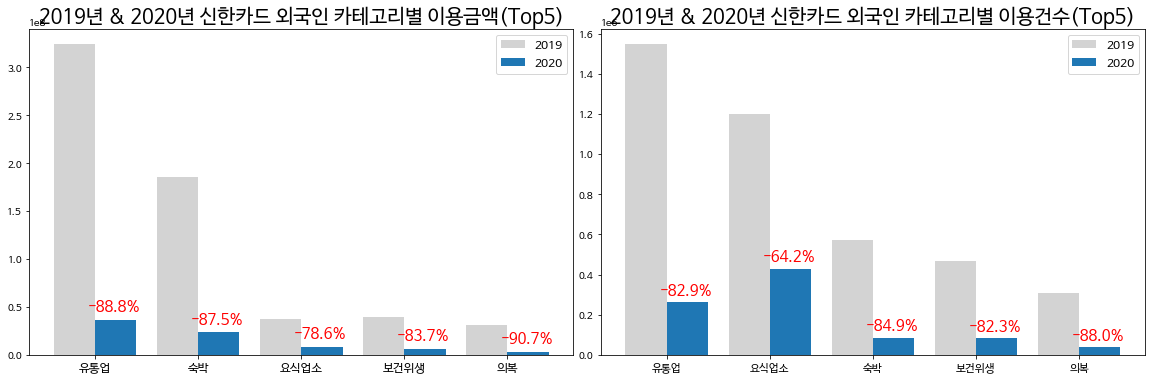

In [ ]:
scf_cat_bar_amt = scf_cat_bar.loc['USE_AMT'].reset_index()
scf_cat_bar_cnt = scf_cat_bar.loc['USE_CNT'].sort_values(by=2019,ascending=False).reset_index()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
plt.subplots_adjust(wspace = 0.05) # hspace = 0.2

ax1.bar(scf_cat_bar_amt.index-0.2, scf_cat_bar_amt.loc[:,2019], width=0.4, color = 'lightgrey', label="2019")
ax1.bar(scf_cat_bar_amt.index+0.2, scf_cat_bar_amt.loc[:,2020], width=0.4, label="2020")
for i in range(5):
  # ax1.plot([i-0.2,i+0.2],scf_cat_bar_amt.iloc[i,1:3],marker='o',color='r',linestyle='--')
  ax1.text(x=i-0.07,y=scf_cat_bar_amt.iloc[i,2]+10000000,s=(str(round(scf_cat_bar_amt.iloc[i,3],1))+'%'),color='r',fontsize=15)
ax1.set_title('2019년 & 2020년 신한카드 외국인 카테고리별 이용금액(Top5)', fontsize=20)
ax1.legend(prop={'size': 12})
ax1.set_xticks(np.array(range(5)))
ax1.set_xticklabels(list(scf_cat_bar_amt.MCT_CAT_CD),fontsize=12)


ax2.bar(scf_cat_bar_cnt.index-0.2, scf_cat_bar_cnt.loc[:,2019], width=0.4, color = 'lightgrey', label="2019")
ax2.bar(scf_cat_bar_cnt.index+0.2, scf_cat_bar_cnt.loc[:,2020], width=0.4, label="2020")
for i in range(5):
  # ax2.plot([i-0.2,i+0.2],scf_cat_bar_cnt.iloc[i,1:3],marker='o',color='r',linestyle='--')
  ax2.text(x=i-0.07,y=scf_cat_bar_cnt.iloc[i,2]+40000,s=(str(round(scf_cat_bar_cnt.iloc[i,3],1))+'%'),color='r',fontsize=15)
ax2.set_title('2019년 & 2020년 신한카드 외국인 카테고리별 이용건수(Top5)', fontsize=20)
ax2.legend(prop={'size': 12})
ax2.set_xticks(np.array(range(5)))
ax2.set_xticklabels(list(scf_cat_bar_cnt.MCT_CAT_CD),fontsize=11)

Text(0.5, 1.0, '신한카드 외국인 카테고리별 이용건수 증감률(%)')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



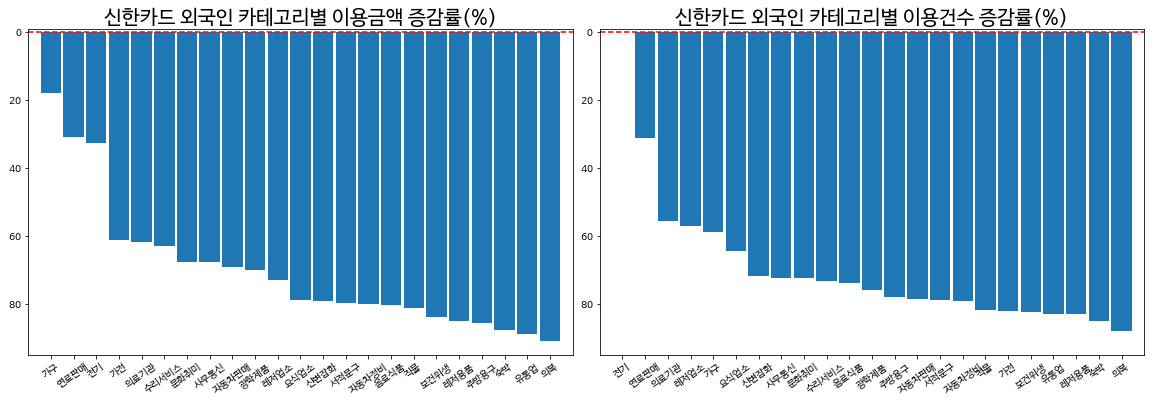

In [ ]:
# 전체 데이터 주차별 성장률 그래프

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
plt.subplots_adjust(wspace = 0.05) # hspace = 0.2

ax1.bar(scf_cat_gr.xs('USE_AMT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,scf_cat_gr.xs('USE_AMT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).증감률, width=0.9)
ax1.set_xlim(-1,23)
ax1.set_ylim(-95,1)
ax1.set_xticklabels(scf_cat_gr.xs('USE_AMT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,rotation=35)
ax1.set_title('신한카드 외국인 카테고리별 이용금액 증감률(%)', fontsize=20)
ax1.axhline(y=0, color='r',linestyle='--')

ax2.bar(scf_cat_gr.xs('USE_CNT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,scf_cat_gr.xs('USE_CNT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).증감률, width=0.9)
ax2.set_xlim(-1,23)
ax2.set_ylim(-95,1)
ax2.set_xticklabels(scf_cat_gr.xs('USE_CNT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,rotation=35)
ax2.axhline(y=0, color='r',linestyle='--')
ax2.set_title('신한카드 외국인 카테고리별 이용건수 증감률(%)', fontsize=20)

